In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import mxnet as mx
import cv2
import os
import sys
import glob
sys.path.append('/users/wangdexun/insightface-deploy/')
from face_detection import MtcnnDetector
from matplotlib import pyplot as plt
from pathlib import PurePath, Path
from umeyama import umeyama
from multiprocessing import Pool
from tqdm import tqdm
from functools import partial

/ada/anaconda3/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


Create MTCNN and its forward pass functions

In [2]:
WEIGHTS_PATH = '/users/wangdexun/insightface-deploy/face_detection/mtcnn-model/'

face_detector=MtcnnDetector(model_folder=WEIGHTS_PATH,
                            ctx=mx.gpu(0),
                            factor=0.709,
                            minsize=30,
                            accurate_landmark=True)

/home/ubuntu/.local/lib/python3.6/site-packages/mxnet/model.py:928: DeprecationWarning: mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.
  **kwargs)


Functions for face detection and alignment

In [126]:
def get_tar_landmarks(img):
    """    
    img: detected face image
    """         
    ratio_landmarks = [
        (0.31339227236234224, 0.3259269274198092),
        (0.31075140146108776, 0.7228453709528997),
        (0.5523683107816256, 0.5187296867370605),
        (0.7752419985257663, 0.37262483743520886),
        (0.7759613623985877, 0.6772957581740159)]   
        
    img_size = img.shape
    tar_landmarks = [(int(xy[1]*img_size[1]), 
                      int(xy[0]*img_size[0])) for xy in ratio_landmarks]
    return tar_landmarks

def landmarks_match_mtcnn(src_img, src_landmarks, tar_landmarks, img_size): 
    """
    umeyama(src, dst, estimate_scale)
    landmarks coord. for umeyama should be (width, height) or (y, x)
    """
    src_size = src_img.shape
    M = umeyama(np.array(src_landmarks), np.array(tar_landmarks), True)[0:2] 
    result = cv2.warpAffine(src_img, M, img_size, borderMode=cv2.BORDER_REPLICATE) 
    return result

def process_mtcnn_bbox(bbox, im_shape):
    """Here we process the bbox coord. to a square bbox.
    避免后续resize使五官变形
    """
    x0, y0, x1, y1 = bbox
    h, w = int(y1 - y0), int(x1 - x0)
    radius = int((w+h)/2/2) # todo: int(max(w,h)/2)
    center_x,center_y = int((x1+x0)/2),int((y1+y0)/2)
    new_x0 = max(0,center_x-radius)
    new_y0 = max(0,center_y-radius)
    new_x1 = min(im_shape[1],center_x+radius)
    new_y1 = min(im_shape[0],center_y+radius)
    bbox = (new_x0, new_y0, new_x1, new_y1)
    return bbox

def process_image(img_path,save_dir): 
    global face_detector
    
    # run detector
    input_img = cv2.imread(img_path)
    results = face_detector.detect_face(input_img)
    if results is None:
        return
    
    total_boxes = results[0]
    points = results[1]
    
    max_index=0
    if len(total_boxes)>1:
        bbox_area=(total_boxes[:,2]-total_boxes[:,0])*(total_boxes[:,3]-total_boxes[:,1])
        max_index=np.argmax(bbox_area)
    
    bbox=total_boxes[max_index][:4]
    landmark=points[max_index].reshape((2,5)).T
    
    face_bbox=process_mtcnn_bbox(bbox,input_img.shape)
    x0,y0,x1,y1=face_bbox
    det_face_img = input_img[y0:y1,x0:x1,:]
    
    # get src/tar landmarks
    src_landmarks = landmark
    tar_landmarks = get_tar_landmarks(det_face_img)
    
    # align detected face
    h, w = det_face_img.shape[:2]
    aligned_det_face_img = landmarks_match_mtcnn(input_img, src_landmarks, tar_landmarks,(w,h))
    
    # binary mask on the eyes  
    bm = np.zeros_like(input_img)
    bm[int(src_landmarks[0][1]-h/15):int(src_landmarks[0][1]+h/15),
       int(src_landmarks[0][0]-w/8):int(src_landmarks[0][0]+w/8),:] = 255
    bm[int(src_landmarks[1][1]-h/15):int(src_landmarks[1][1]+h/15),
       int(src_landmarks[1][0]-w/8):int(src_landmarks[1][0]+w/8),:] = 255
    bm = landmarks_match_mtcnn(bm, src_landmarks, tar_landmarks,(w,h))
    
    # save
    _,img_name=os.path.split(img_path)

    fname = os.path.join(save_dir,'aligned_faces',img_name)
    os.makedirs(os.path.dirname(fname),exist_ok=True)
    cv2.imwrite(fname, aligned_det_face_img)

    fname = os.path.join(save_dir,'raw_faces',img_name)
    os.makedirs(os.path.dirname(fname),exist_ok=True)
    cv2.imwrite(fname, det_face_img)
     
    fname = os.path.join(save_dir,'binary_masks_eyes',img_name)
    os.makedirs(os.path.dirname(fname),exist_ok=True)
    cv2.imwrite(fname, bm)
    
def detect_align_face(data_dir,save_dir):
    images=glob.glob(os.path.join(data_dir,'*.*g'))
    os.makedirs(save_dir,exist_ok=True)
    with tqdm(total=len(images),desc='Processing images') as pbar:
        with Pool(processes=12) as p:
            worker=partial(process_image,save_dir=save_dir)
            for _ in p.imap(worker,images):
                pbar.update()

In [127]:
detect_align_face('../data/wdx/original/','./faces/wdx')

Processing images: 100%|██████████| 15872/15872 [04:45<00:00, 55.61it/s]


In [128]:
detect_align_face('../data/ccj/original/','./faces/ccj')

Processing images: 100%|██████████| 12341/12341 [03:05<00:00, 66.66it/s]


In [129]:
detect_align_face('../data/wxb/original/','./faces/wxb')

Processing images: 100%|██████████| 10826/10826 [02:12<00:00, 81.65it/s]


In [130]:
detect_align_face('../data/leo/original/','./faces/leo')

Processing images: 100%|██████████| 15494/15494 [03:48<00:00, 73.73it/s]


Load 12307 images in total


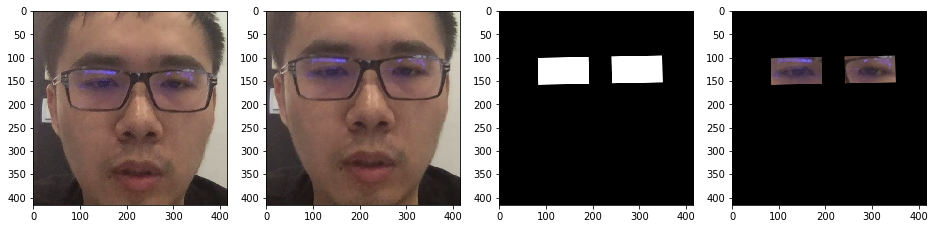

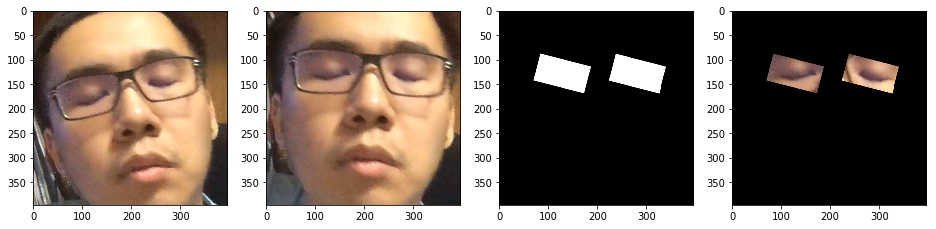

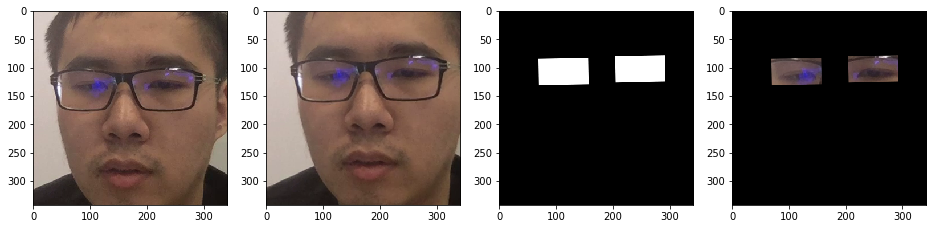

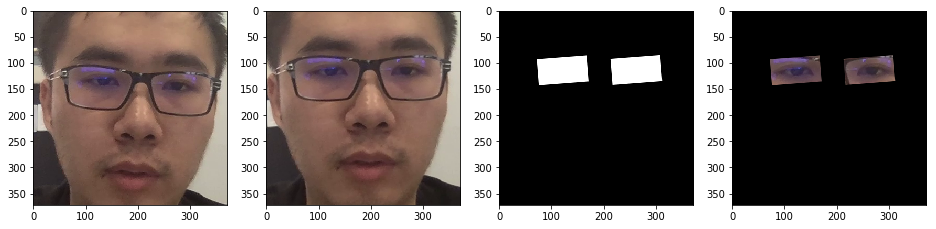

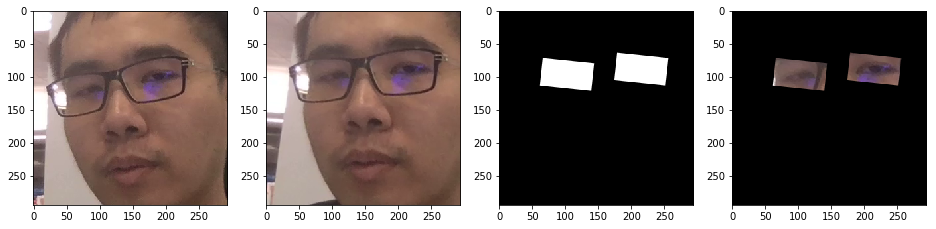

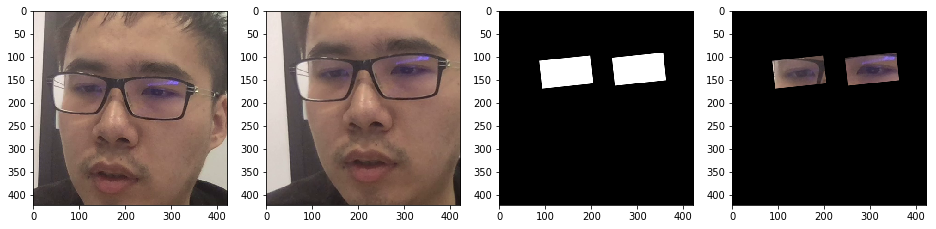

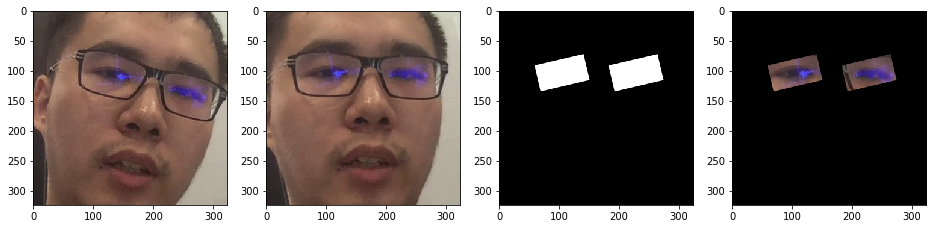

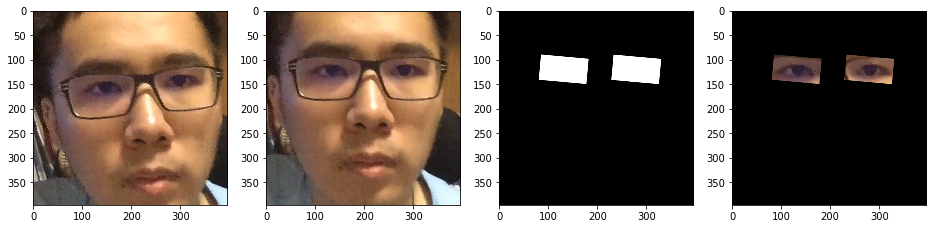

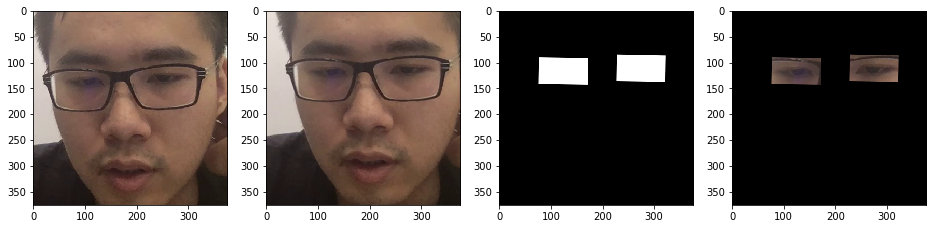

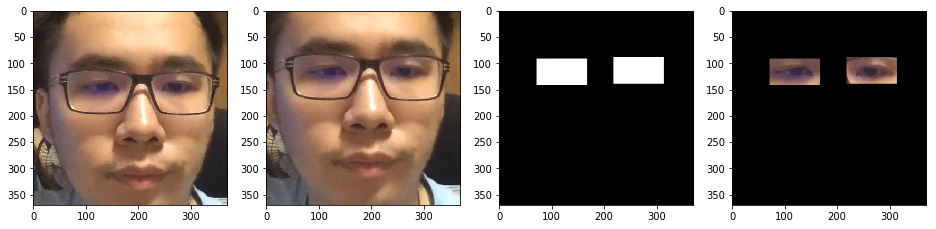

In [136]:
# Plot examples
data_dir='./faces/ccj/'
images=os.listdir(os.path.join(data_dir,'raw_faces'))
print('Load {} images in total'.format(len(images)))
for i in np.random.choice(images,10,replace=False):
    dir_names=['raw_faces','aligned_faces','binary_masks_eyes']
    fig,axes=plt.subplots(1,4,figsize=(16,9))
    raw_img=cv2.imread(os.path.join(data_dir,dir_names[0],i))
    axes[0].imshow(raw_img[...,::-1])
    aligned_img=cv2.imread(os.path.join(data_dir,dir_names[1],i))
    axes[1].imshow(aligned_img[...,::-1])
    bm_img=cv2.imread(os.path.join(data_dir,dir_names[2],i))
    axes[2].imshow(bm_img[...,::-1])
    mask_img=np.multiply(aligned_img,bm_img/255)
    mask_img=mask_img.astype(np.uint8)
    axes[3].imshow(mask_img[...,::-1])
    plt.show()

In [ ]:
# def get_src_landmarks(x0, y0, x1, y1, pnts):
#     """
#     x0, x1, y0, y1: (smoothed) bbox coord.
#     pnts: landmarks predicted by MTCNN
#     """    
#     src_landmarks = [(int(pnts[i][0]-x0), 
#                       int(pnts[i][1]-y0)) for i in range(5)]
#     return src_landmarks

# def get_tar_landmarks(img):
#     """    
#     img: detected face image
#     """         
#     ratio_landmarks = [
#         (0.31339227236234224, 0.3259269274198092),
#         (0.31075140146108776, 0.7228453709528997),
#         (0.5523683107816256, 0.5187296867370605),
#         (0.7752419985257663, 0.37262483743520886),
#         (0.7759613623985877, 0.6772957581740159)]   
        
#     img_size = img.shape
#     tar_landmarks = [(int(xy[1]*img_size[1]), 
#                       int(xy[0]*img_size[0])) for xy in ratio_landmarks]
#     return tar_landmarks

# def landmarks_match_mtcnn(src_img, src_landmarks, tar_landmarks): 
#     """
#     umeyama(src, dst, estimate_scale)
#     landmarks coord. for umeyama should be (width, height) or (y, x)
#     """
#     src_size = src_img.shape
#     M = umeyama(np.array(src_landmarks), np.array(tar_landmarks), True)[0:2] 
#     result = cv2.warpAffine(src_img, M, (src_size[1], src_size[0]), borderMode=cv2.BORDER_REPLICATE) 
#     return result

# def process_mtcnn_bbox(bbox, im_shape):
#     """Here we process the bbox coord. to a square bbox.
#     避免后续resize使五官变形
#     """
#     x0, y0, x1, y1 = bbox
#     h, w = int(y1 - y0), int(x1 - x0)
#     radius = int((w+h)/2/2) # todo: int(max(w,h)/2)
#     center_x,center_y = int((x1+x0)/2),int((y1+y0)/2)
#     new_x0 = max(0,center_x-radius)
#     new_y0 = max(0,center_y-radius)
#     new_x1 = min(im_shape[1],center_x+radius)
#     new_y1 = min(im_shape[0],center_y+radius)
#     bbox = (new_x0, new_y0, new_x1, new_y1)
#     return bbox

# def process_image(img_path,save_dir): 
#     global face_detector
    
#     # run detector
#     input_img=cv2.imread(img_path)
#     results = face_detector.detect_face(input_img)
#     if results is None:
#         return
    
#     total_boxes = results[0]
#     points = results[1]
    
#     max_index=0
#     if len(total_boxes)>1:
#         bbox_area=(total_boxes[:,2]-total_boxes[:,0])*(total_boxes[:,3]-total_boxes[:,1])
#         max_index=np.argmax(bbox_area)
    
#     bbox=total_boxes[max_index][:4]
#     landmark=points[max_index].reshape((2,5)).T
    
#     face_bbox=process_mtcnn_bbox(bbox,input_img.shape)
#     x0,y0,x1,y1=face_bbox
#     det_face_img = input_img[y0:y1,x0:x1,:]
    
#     # get src/tar landmarks
#     src_landmarks = get_src_landmarks(x0, y0, x1, y1, landmark)
#     tar_landmarks = get_tar_landmarks(det_face_img)
    
#     # align detected face
#     aligned_det_face_img = landmarks_match_mtcnn(det_face_img, 
#                                                  src_landmarks, 
#                                                  tar_landmarks)
#     # binary mask on the eyes  
#     bm = np.zeros_like(det_face_img)
#     h, w = bm.shape[:2]
#     bm[int(src_landmarks[0][1]-h/15):int(src_landmarks[0][1]+h/15),
#        int(src_landmarks[0][0]-w/8):int(src_landmarks[0][0]+w/8),:] = 255
#     bm[int(src_landmarks[1][1]-h/15):int(src_landmarks[1][1]+h/15),
#        int(src_landmarks[1][0]-w/8):int(src_landmarks[1][0]+w/8),:] = 255
#     bm = landmarks_match_mtcnn(bm, src_landmarks, tar_landmarks)
    
#     # save
#     _,img_name=os.path.split(img_path)

#     fname = os.path.join(save_dir,'aligned_faces',img_name)
#     os.makedirs(os.path.dirname(fname),exist_ok=True)
#     cv2.imwrite(fname, aligned_det_face_img)

#     fname = os.path.join(save_dir,'raw_faces',img_name)
#     os.makedirs(os.path.dirname(fname),exist_ok=True)
#     cv2.imwrite(fname, det_face_img)
     
#     fname = os.path.join(save_dir,'binary_masks_eyes',img_name)
#     os.makedirs(os.path.dirname(fname),exist_ok=True)
#     cv2.imwrite(fname, bm)
    
# def detect_align_face(data_dir,save_dir):
#     images=glob.glob(os.path.join(data_dir,'*.*g'))
#     os.makedirs(save_dir,exist_ok=True)
#     with tqdm(total=len(images),desc='Processing images') as pbar:
#         with Pool(processes=12) as p:
#             worker=partial(process_image,save_dir=save_dir)
#             for _ in p.imap(worker,images):
#                 pbar.update()

Start face detection

Default input video filename: `INPUT_VIDEO.mp4`

In [26]:
global frames
frames = 0

# configuration
save_interval = 6 # perform face detection every {save_interval} frames
fn_input_video = "../data/wyf/wyf5.mp4"

output = './faces/videos/dummy.mp4'
clip1 = VideoFileClip(fn_input_video)
clip = clip1.fl_image(process_video)#.subclip(0,3) #NOTE: this function expects color images!!
clip.write_videofile(output, audio=False)
clip1.reader.close()

[MoviePy] >>>> Building video ./faces/videos/dummy.mp4
[MoviePy] Writing video ./faces/videos/dummy.mp4


100%|██████████| 3992/3992 [07:18<00:00,  9.10it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./faces/videos/dummy.mp4 

